# Best and worst molecules analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from scipy import stats
from torch.nn.utils.rnn import pad_sequence
from sklearn.neural_network import MLPRegressor
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.metrics import mean_squared_error, r2_score
import time

## Uploading data from file

In [2]:
DATA_PATH = "../../../data/4_best_predictions/"
FILE_PATTERN = "count_fingerprint_predictions_{0}.csv"

In [3]:
valid = pd.read_csv(DATA_PATH + FILE_PATTERN.format('valid'))
test = pd.read_csv(DATA_PATH + FILE_PATTERN.format('test'))

In [4]:
compare_data = pd.DataFrame({'smiles': test.smiles, 'y_expected': test.logp, 'y_predicted': test.logp_pred})

In [5]:
X_valid_mol = [Chem.MolFromSmiles(x) for x in valid.smiles]
X_test_mol = [Chem.MolFromSmiles(x) for x in test.smiles]

In [6]:
y_test = test.logp
y_valid = valid.logp

## Getting the data to compare

In [7]:
compare_data.head()

,smiles,y_expected,y_predicted
0,CC(=O)NC(Cc1ccccc1)C(=O)NC(Cc1ccccc1)C(=O)N(C)...,2.63,1.891084
1,CC(C)n1c(/C=C/[C@@H](O)C[C@@H](O)CC(=O)O)c(-c2...,4.17,3.885702
2,CCS(=O)c1sc(C(C)=O)c(N)c1C#N,1.82,1.848937
3,O=P(Oc1ccccc1)(Oc1ccccc1)Oc1ccccc1,4.59,4.157767
4,OC1(c2cc(Cl)ccc2Cl)CCCCC1n1cncn1,3.24,3.712326


In [8]:
compare_data.shape

(2067, 3)

In [9]:
compare_data['error'] = (compare_data.y_expected - compare_data.y_predicted) ** 2

In [10]:
compare_data.sort_values(by=['error'], ascending=False).head()

,smiles,y_expected,y_predicted,error
1029,CCCCCCCCCCCCCCP(C)(C)(C)Br,2.06,8.383262,39.983645
243,Brc1cc(Br)c(Br)c(-c2c(Br)c(Br)cc(Br)c2Br)c1Br,5.50,10.769231,27.764795
658,CC1OC(OC2C(O)CC(OC3C(O)CC(OC4CCC5(C)C(CCC6C5CC...,-1.77,1.568261,11.143986
1727,O=S(=O)(O)c1cc(N=c2[nH]c(N3CCOCC3)nc(=Nc3ccccc...,1.48,4.743644,10.651374
1923,CC(N)(C(=O)O)c1cccc2ccccc12,-0.22,2.547849,7.660989


In [11]:
compare_data.sort_values(by=['error'], ascending=True).head()

,smiles,y_expected,y_predicted,error
24,CC(=O)c1ccc2cccccc1-2,2.87,2.869541,2.111261e-07
1969,Cn1c(=O)sc2ccccc21,1.98,1.980988,9.765792e-07
1123,c1ccc2cc3sccc3cc2c1,4.50,4.498905,1.198645e-06
1318,Clc1ccccc1N1CCNCC1,2.13,2.128867,1.283732e-06
994,CCCCOc1ccc([N+](=O)[O-])cc1,3.50,3.501387,1.924324e-06


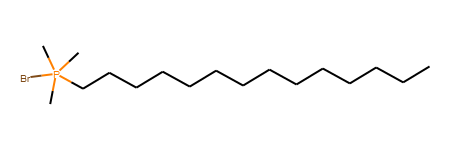

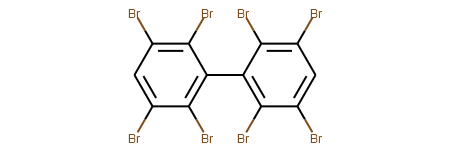

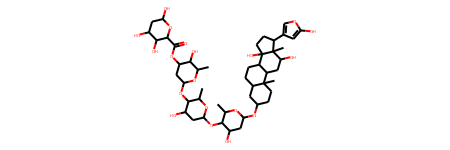

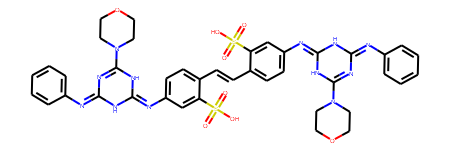

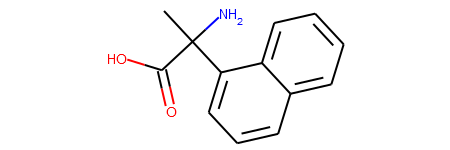

In [12]:
for mol in compare_data.sort_values(by=['error'], ascending=False).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

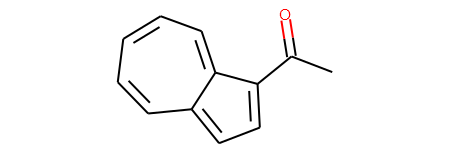

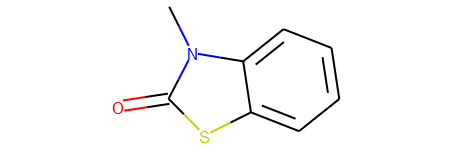

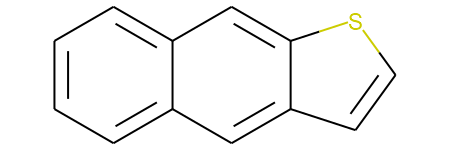

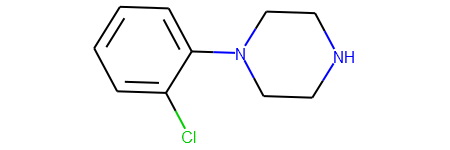

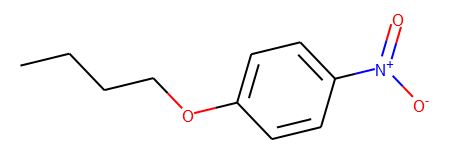

In [13]:
for mol in compare_data.sort_values(by=['error'], ascending=True).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

In [14]:
compare_data = compare_data.sort_values(by=['error'])

## Creating comparing function
### The features to compare:
- The count of atoms
- The count of rings
- The count of not organogens atoms
- The percent of not organogens atoms
- The percent of aromatic (benzene) rings out of all rings
- The count and percent of aromatic bonds
- The symmetry of molecules

In [15]:
def create_statistics(vals):
    values = vals.copy()
    mols = [Chem.MolFromSmiles(x) for x in values.smiles]
    
    atom_count = [mol.GetNumAtoms() for mol in mols]
    values['atom_count'] = pd.Series(atom_count)
    
    values['ring_count'] = pd.Series([mol.GetRingInfo().NumRings() for mol in mols])
    
    mol_atoms = [mol.GetAtoms() for mol in mols]
    non_simple_atom_count = [sum((num.GetAtomicNum() not in [1, 6, 8, 7]) for num in m_atoms) for m_atoms in mol_atoms]
    values['non_organogens_count'] = pd.Series(non_simple_atom_count)
    
    values['non_organogens_percent'] = values.non_organogens_count / values.atom_count *100
    
    benzene_smiles = 'C1=CC=CC=C1'
    pattern = Chem.MolFromSmiles(benzene_smiles)
    values['aromatic_count'] = pd.Series([len(mol.GetSubstructMatches(pattern)) for mol in mols])
    
    values['aromatic_rings_percent'] = values.aromatic_count / values.ring_count *100
    values['aromatic_rings_percent'] = values['aromatic_rings_percent'].fillna(0)
    
    values['bond_count'] =  [len(mol.GetBonds()) for mol in mols]
    values['aromatic_bond_count'] = [sum(bond.GetIsAromatic() for bond in mol.GetBonds()) for mol in mols]
    values['aromatic_bond_percent'] = values.aromatic_bond_count / values.bond_count * 100
    
    values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in mols]
    values['is_symmetric'] =  [(len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)])) for values in values_list]
    
    return values

## Analyzing the data features

In [16]:
compare_data_with_stats = create_statistics(compare_data)

In [17]:
compare_data_with_stats.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
24,CC(=O)c1ccc2cccccc1-2,2.87,2.869541,2.111261e-07,16,2,1,6.250000,2,100.0,14,10,71.428571,False
1969,Cn1c(=O)sc2ccccc21,1.98,1.980988,9.765792e-07,21,1,1,4.761905,1,100.0,12,10,83.333333,False
1123,c1ccc2cc3sccc3cc2c1,4.50,4.498905,1.198645e-06,16,2,1,6.250000,1,50.0,15,15,100.000000,False
1318,Clc1ccccc1N1CCNCC1,2.13,2.128867,1.283732e-06,18,1,1,5.555556,1,100.0,14,6,42.857143,False
994,CCCCOc1ccc([N+](=O)[O-])cc1,3.50,3.501387,1.924324e-06,15,2,0,0.000000,1,50.0,14,6,42.857143,False


#### Splitting data into 3 parts

In [18]:
data = []
for i in range(3):
    data.append(compare_data_with_stats.take([j for j in range(i * 1894 // 3, min((i + 1) * 1894 // 3, 1894))]))

In [19]:
data[0].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,631.000000,631.000000,6.310000e+02,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,2.218177,2.228878,7.875972e-03,17.641838,1.776545,0.870048,5.627553,0.961965,56.500264,17.150555,7.654517,45.801694
std,1.680735,1.681548,6.994076e-03,7.847864,1.181533,1.330559,9.479344,0.761251,41.379365,7.044608,4.458394,22.941116
min,-2.280000,-2.171511,2.111261e-07,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,1.195000,1.170590,1.243350e-03,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,6.000000,33.333333
50%,2.050000,2.087740,6.067165e-03,17.000000,2.000000,0.000000,0.000000,1.000000,50.000000,16.000000,6.000000,46.153846
75%,3.175000,3.150673,1.361013e-02,21.000000,2.000000,1.000000,8.333333,1.000000,100.000000,20.500000,11.000000,60.000000
max,8.600000,8.658198,2.328357e-02,66.000000,9.000000,8.000000,100.000000,4.000000,100.000000,44.000000,28.000000,100.000000


In [20]:
data[1].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,2.135325,2.162693,0.061628,17.316957,1.757528,0.908082,5.477932,0.938193,54.277790,17.207607,7.540412,44.253831
std,1.790120,1.789749,0.027667,6.886911,1.129617,1.399926,8.635946,0.756548,41.122332,7.249937,4.697977,23.881842
min,-2.450000,-2.294668,0.023361,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.905000,0.904612,0.037447,12.500000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,6.000000,31.578947
50%,2.010000,1.963458,0.056890,16.000000,2.000000,0.000000,0.000000,1.000000,50.000000,16.000000,6.000000,46.153846
75%,3.200000,3.153108,0.083682,21.000000,2.000000,1.000000,8.333333,1.000000,100.000000,21.000000,11.000000,60.000000
max,8.070000,8.371706,0.119801,52.000000,7.000000,10.000000,80.000000,5.000000,100.000000,59.000000,27.000000,100.000000


In [21]:
data[2].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000
mean,2.130253,2.206618,0.328950,17.816456,1.806962,0.797468,4.896490,0.914557,53.919907,19.775316,7.737342,40.533920
std,1.888958,1.875847,0.189841,8.300489,1.282856,1.303461,8.654218,0.754685,41.423856,9.153221,5.130685,23.704465
min,-3.400000,-2.543652,0.119831,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000
25%,0.800000,0.998952,0.172259,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,14.000000,6.000000,26.086957
50%,2.195000,2.196317,0.265964,16.000000,2.000000,0.000000,0.000000,1.000000,50.000000,18.000000,6.000000,40.740741
75%,3.345000,3.437187,0.448553,21.000000,2.000000,1.000000,7.142857,1.000000,100.000000,24.000000,11.250000,55.555556
max,8.030000,8.622525,0.832232,65.000000,8.000000,8.000000,80.000000,4.000000,100.000000,65.000000,30.000000,100.000000


## Check repeting patterns in the middle of the dataset
Hypothesis: badly predicted molecules are symmetric (like 1, 3, 5 worst molecules)

The simplest way to check: take 20 random molecules from the best/middle/worst part.

In [22]:
best = data[0].reset_index().drop(columns=['index'])

In [23]:
best.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,CC(=O)c1ccc2cccccc1-2,2.87,2.869541,2.111261e-07,16,2,1,6.250000,2,100.0,14,10,71.428571,False
1,Cn1c(=O)sc2ccccc21,1.98,1.980988,9.765792e-07,21,1,1,4.761905,1,100.0,12,10,83.333333,False
2,c1ccc2cc3sccc3cc2c1,4.50,4.498905,1.198645e-06,16,2,1,6.250000,1,50.0,15,15,100.000000,False
3,Clc1ccccc1N1CCNCC1,2.13,2.128867,1.283732e-06,18,1,1,5.555556,1,100.0,14,6,42.857143,False
4,CCCCOc1ccc([N+](=O)[O-])cc1,3.50,3.501387,1.924324e-06,15,2,0,0.000000,1,50.0,14,6,42.857143,False


In [24]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=10))

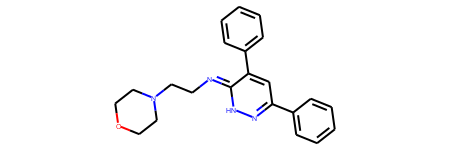

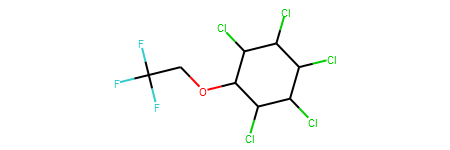

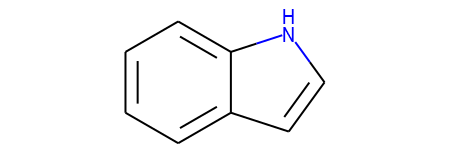

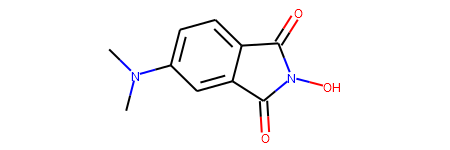

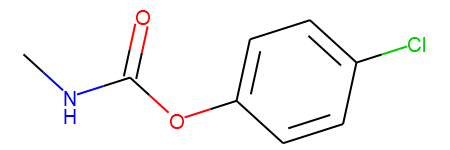

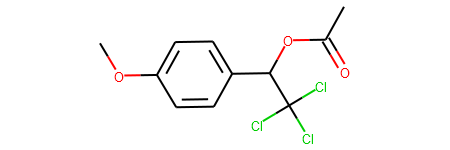

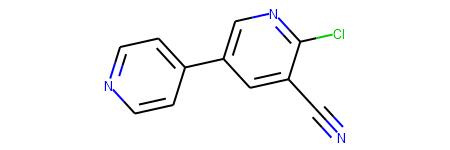

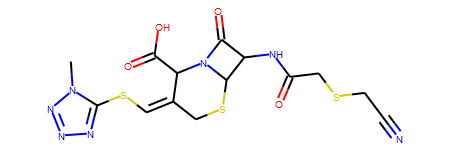

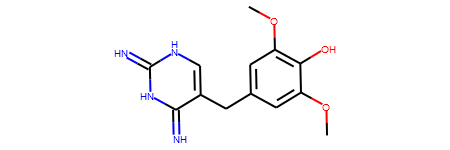

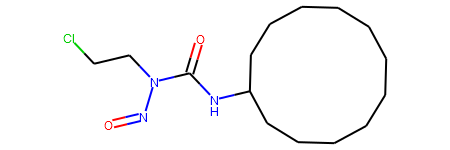

In [25]:
for smiles in best.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [26]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=20))

In [27]:
middle = data[1].reset_index().drop(columns=['index'])

In [28]:
middle.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,CS(=O)(=O)ON1C(=O)c2ccc([N+](=O)[O-])cc2C1=O,1.71,1.557158,0.023361,9,1,2,22.222222,1,100.0,20,6,30.000000,False
1,CC(C)(C)N(NC(=O)c1ccccc1F)C(=O)c1ccccc1Cl,2.63,2.782901,0.023379,20,1,0,0.000000,1,100.0,25,12,48.000000,False
2,COC(=O)/C=C/c1ccccc1,2.62,2.773055,0.023426,15,0,3,20.000000,0,0.0,12,6,50.000000,False
3,CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)C...,1.43,1.276639,0.023520,19,1,0,0.000000,1,100.0,36,0,0.000000,False
4,COc1cccc(C(=O)NN(C(=O)c2cc(C)cc(C)c2)C(C)(C)C)c1C,3.70,3.853701,0.023624,14,2,0,0.000000,1,50.0,28,12,42.857143,False


In [29]:
middle.shape

(631, 14)

In [30]:
indices = pd.Series(np.random.randint(631, size=10))

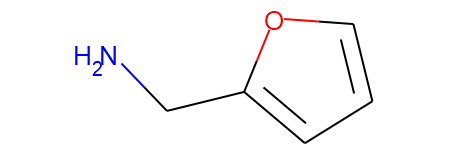

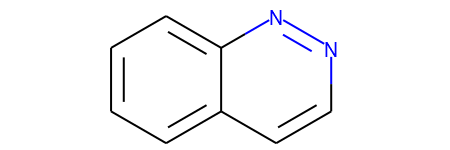

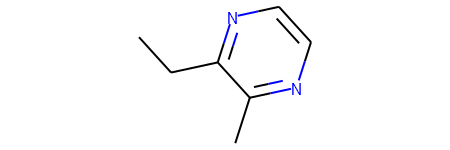

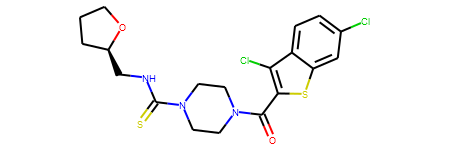

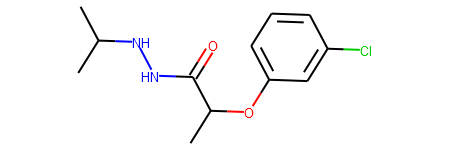

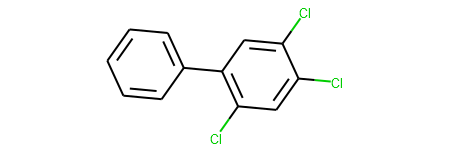

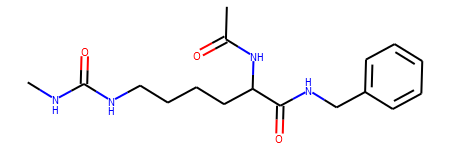

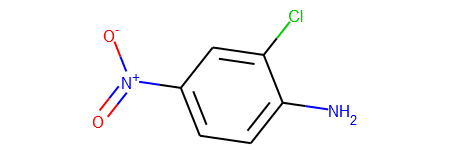

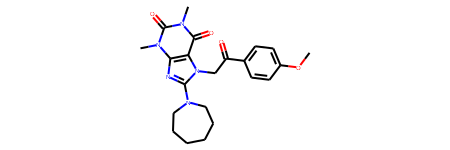

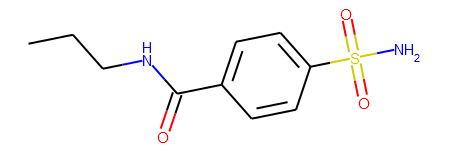

In [31]:
for smiles in middle.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [32]:
worst = data[2].reset_index().drop(columns=['index'])

In [33]:
indices = pd.Series(np.random.randint(631, size=10))

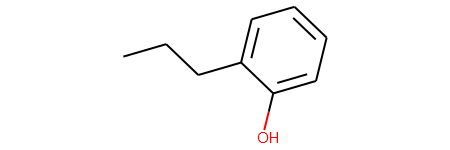

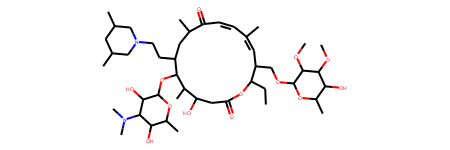

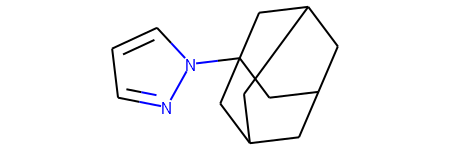

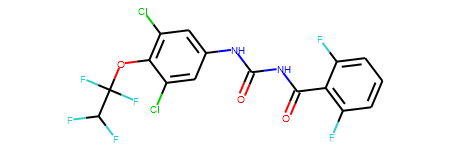

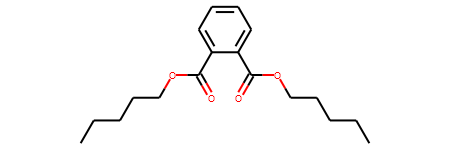

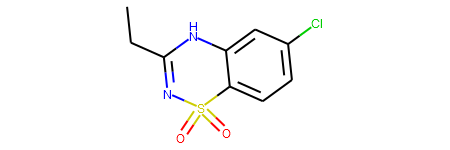

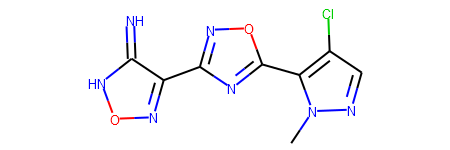

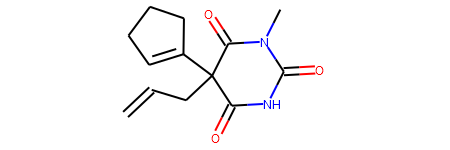

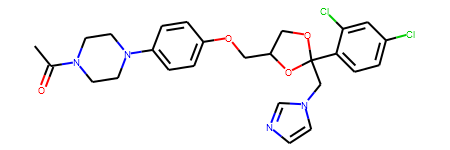

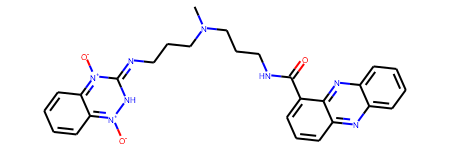

In [34]:
for smiles in worst.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

#### Taking best and worst predicted values

In [35]:
n_values = 200

In [36]:
best_n_vals = compare_data_with_stats.take([j for j in range(n_values)])

In [37]:
worst_n_vals = compare_data_with_stats.take([j for j in range( len(compare_data.smiles) - 1, len(compare_data.smiles) - 1 - n_values, -1)])

In [38]:
best_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
24,CC(=O)c1ccc2cccccc1-2,2.87,2.869541,2.111261e-07,16,2,1,6.250000,2,100.0,14,10,71.428571,False
1969,Cn1c(=O)sc2ccccc21,1.98,1.980988,9.765792e-07,21,1,1,4.761905,1,100.0,12,10,83.333333,False
1123,c1ccc2cc3sccc3cc2c1,4.50,4.498905,1.198645e-06,16,2,1,6.250000,1,50.0,15,15,100.000000,False
1318,Clc1ccccc1N1CCNCC1,2.13,2.128867,1.283732e-06,18,1,1,5.555556,1,100.0,14,6,42.857143,False
994,CCCCOc1ccc([N+](=O)[O-])cc1,3.50,3.501387,1.924324e-06,15,2,0,0.000000,1,50.0,14,6,42.857143,False


In [39]:
worst_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
1029,CCCCCCCCCCCCCCP(C)(C)(C)Br,2.06,8.383262,39.983645,16,1,0,0.000000,1,100.0,18,0,0.000000,False
243,Brc1cc(Br)c(Br)c(-c2c(Br)c(Br)cc(Br)c2Br)c1Br,5.50,10.769231,27.764795,26,2,6,23.076923,2,100.0,21,12,57.142857,True
658,CC1OC(OC2C(O)CC(OC3C(O)CC(OC4CCC5(C)C(CCC6C5CC...,-1.77,1.568261,11.143986,19,1,0,0.000000,1,100.0,74,5,6.756757,False
1727,O=S(=O)(O)c1cc(N=c2[nH]c(N3CCOCC3)nc(=Nc3ccccc...,1.48,4.743644,10.651374,15,1,2,13.333333,1,100.0,69,36,52.173913,True
1923,CC(N)(C(=O)O)c1cccc2ccccc12,-0.22,2.547849,7.660989,14,2,0,0.000000,1,50.0,17,11,64.705882,False


In [40]:
best_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,200.000000,200.000000,2.000000e+02,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,2.238750,2.238313,7.455395e-04,17.465000,1.825000,0.855000,5.626351,0.955000,55.050000,17.205000,7.965000,48.123743
std,1.631602,1.630990,6.376530e-04,7.473153,1.113812,1.289297,8.715763,0.731883,40.644209,7.344569,4.419438,22.483946
min,-1.650000,-1.680147,2.111261e-07,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,1.277500,1.303328,1.391150e-04,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,6.000000,33.333333
50%,2.105000,2.094545,6.640222e-04,17.000000,2.000000,0.000000,0.000000,1.000000,50.000000,15.000000,6.000000,50.000000
75%,3.140000,3.169748,1.130780e-03,21.000000,2.000000,1.000000,7.769231,1.000000,100.000000,21.000000,11.000000,61.111111
max,8.200000,8.239267,2.180712e-03,52.000000,6.000000,5.000000,45.454545,3.000000,100.000000,41.000000,27.000000,100.000000


In [41]:
worst_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,2.155300,2.267942,2.202581,18.170000,1.830000,0.800000,4.589627,0.950000,56.546429,22.640000,8.550000,37.087497
std,2.216852,2.083687,3.613645,8.093741,1.116842,1.407089,7.595876,0.755216,41.588129,13.022223,7.213715,25.507310
min,-3.700000,-2.650577,0.750289,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.875000,0.944318,0.919774,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,15.000000,5.000000,14.202658
50%,2.180000,2.243653,1.237387,17.000000,2.000000,0.000000,0.000000,1.000000,50.000000,19.000000,6.000000,41.267422
75%,3.782500,3.601568,2.317309,21.000000,2.000000,1.000000,6.666667,1.000000,100.000000,27.250000,12.000000,55.827669
max,6.700000,10.769231,39.983645,85.000000,7.000000,9.000000,44.444444,5.000000,100.000000,85.000000,36.000000,100.000000


### Check atom_count influence

In [42]:
print(stats.ttest_ind(best_n_vals.atom_count, worst_n_vals.atom_count))

Ttest_indResult(statistic=-0.9050494530913256, pvalue=0.36598671779892455)


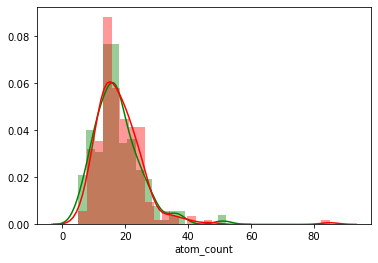

In [43]:
sns.distplot(best_n_vals.atom_count, color='g')
sns.distplot(worst_n_vals.atom_count, color='r')

### Check ring_count influence

In [44]:
print(stats.ttest_ind(best_n_vals.ring_count, worst_n_vals.ring_count))

Ttest_indResult(statistic=-0.044829848395498334, pvalue=0.9642654168639957)


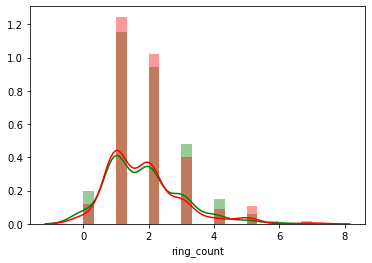

In [45]:
sns.distplot(best_n_vals.ring_count, color='g')
sns.distplot(worst_n_vals.ring_count, color='r')

### Check non_organogens_count influence

In [46]:
print(stats.ttest_ind(best_n_vals.non_organogens_count, worst_n_vals.non_organogens_count))

Ttest_indResult(statistic=0.4075647650716495, pvalue=0.6838123689777087)


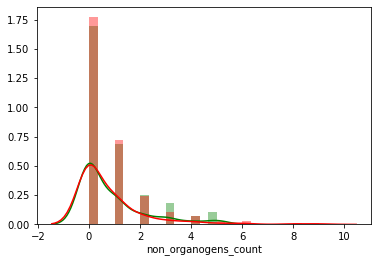

In [47]:
sns.distplot(best_n_vals.non_organogens_count, color='g')
sns.distplot(worst_n_vals.non_organogens_count, color='r')

### Check non_organogens_percent influence

In [48]:
print(stats.ttest_ind(best_n_vals.non_organogens_percent, worst_n_vals.non_organogens_percent))

Ttest_indResult(statistic=1.2681609742638196, pvalue=0.20548178701914643)


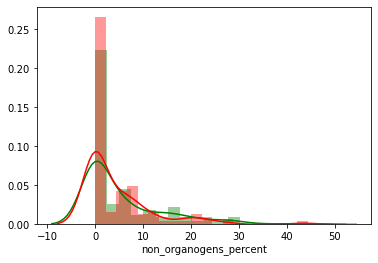

In [49]:
sns.distplot(best_n_vals.non_organogens_percent, color='g')
sns.distplot(worst_n_vals.non_organogens_percent, color='r')

### Check aromatic_count influence

In [50]:
print(stats.ttest_ind(best_n_vals.aromatic_count, worst_n_vals.aromatic_count))

Ttest_indResult(statistic=0.06723670961487203, pvalue=0.9464270243744828)


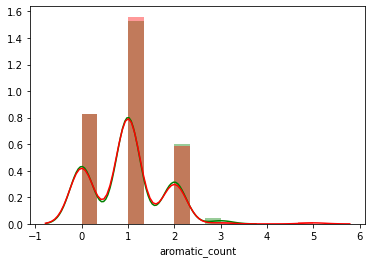

In [51]:
sns.distplot(best_n_vals.aromatic_count, color='g')
sns.distplot(worst_n_vals.aromatic_count, color='r')

### Check aromatic_rings_percent influence

In [52]:
print(stats.ttest_ind(best_n_vals.aromatic_rings_percent, worst_n_vals.aromatic_rings_percent))

Ttest_indResult(statistic=-0.3639273890458934, pvalue=0.7161054801536095)


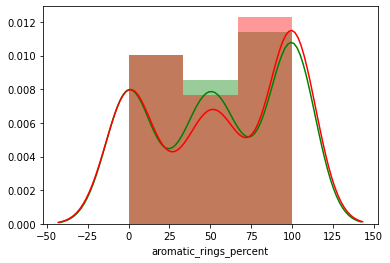

In [53]:
sns.distplot(best_n_vals.aromatic_rings_percent, color='g')
sns.distplot(worst_n_vals.aromatic_rings_percent, color='r')

### Check aromatic bond percent

In [54]:
print(stats.ttest_ind(best_n_vals.aromatic_bond_percent, worst_n_vals.aromatic_bond_percent))

Ttest_indResult(statistic=4.590173882893185, pvalue=5.946760246954523e-06)


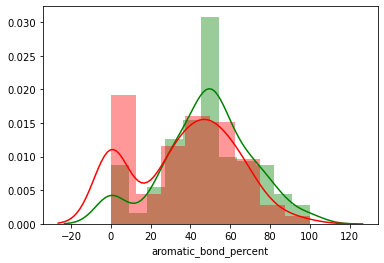

In [55]:
sns.distplot(best_n_vals.aromatic_bond_percent, color='g')
sns.distplot(worst_n_vals.aromatic_bond_percent, color='r')

### Check aromatic bond count

In [56]:
print(stats.ttest_ind(best_n_vals.aromatic_bond_count, worst_n_vals.aromatic_bond_count))

Ttest_indResult(statistic=-0.977930572531048, pvalue=0.3287027007393202)


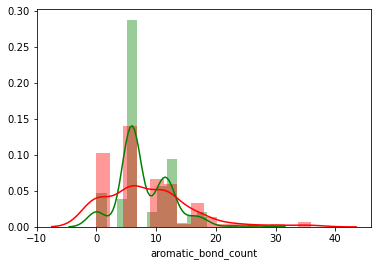

In [57]:
sns.distplot(best_n_vals.aromatic_bond_count, color='g')
sns.distplot(worst_n_vals.aromatic_bond_count, color='r')

### Check symmetric count

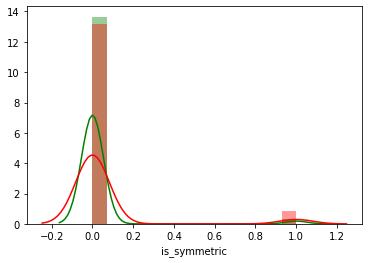

In [58]:
sns.distplot(best_n_vals.is_symmetric, color='g')
sns.distplot(worst_n_vals.is_symmetric, color='r')

### Metrics analysis among symmetric and not symmetric molecules

In [59]:
symmetric_rull = lambda values: (len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)]))

In [67]:
X_test_mol = [Chem.MolFromSmiles(x) for x in compare_data.smiles]

In [68]:
values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in X_test_mol]
symmetric_indices = [symmetric_rull(values) for values in values_list]
not_symmetric_indices = [not e for e in symmetric_indices]

In [69]:
symmetric_y_predicted = compare_data.y_predicted[symmetric_indices]

In [70]:
symmetric_y_expected = compare_data.y_expected[symmetric_indices]

In [71]:
not_symmetric_y_predicted = compare_data.y_predicted[not_symmetric_indices]

In [72]:
not_symmetric_y_expected = compare_data.y_expected[not_symmetric_indices]

In [73]:
print("Test symmetric RMSE =", mean_squared_error(symmetric_y_expected, symmetric_y_predicted, squared=False))
print("Test symmetric R2-score is {0}".format(r2_score(symmetric_y_expected, symmetric_y_predicted)))

Test symmetric RMSE = 0.9332902743708283
Test symmetric R2-score is 0.8355810743971538


In [74]:
print("Test not symmetric RMSE =", mean_squared_error(not_symmetric_y_expected, not_symmetric_y_predicted, squared=False))
print("Test not symmetric R2-score is {0}".format(r2_score(not_symmetric_y_expected, not_symmetric_y_predicted)))

Test not symmetric RMSE = 0.5524699021886343
Test not symmetric R2-score is 0.9065921227250612
